In [154]:
%matplotlib inline
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

In [155]:
from copulas import *
import ndtest # bivariate Kolmogorov-Smirnov

In [156]:
from pandas_datareader import data
import yfinance as yfin
def get(tickers, start, end):
    def multiple(ticker):
        return yfin.download(ticker, start, end, progress=False)
    datas = map(multiple, tickers)
    return pd.concat(datas, keys=tickers,names=['Ticker', 'Date'])

In [157]:
tickers = ["NESTLEIND.NS","DABUR.NS"]
start = pd.to_datetime('2019-07-04')
end = pd.to_datetime('2022-01-03')
df = get(tickers, start, end)
adj_close = df.reset_index().pivot(index='Date', columns='Ticker', values='Adj Close')
returns = np.log(adj_close).diff().dropna()
returns

Ticker,DABUR.NS,NESTLEIND.NS
Date,,
2019-07-05,0.010738,0.006078
2019-07-08,-0.014716,-0.013086
2019-07-09,0.012135,-0.009741
2019-07-10,0.008578,-0.011757
2019-07-11,-0.001221,-0.003786
...,...,...
2021-12-27,-0.003999,0.004057
2021-12-28,0.001779,0.002724
2021-12-29,0.007351,0.002304


<Axes: xlabel='Date'>

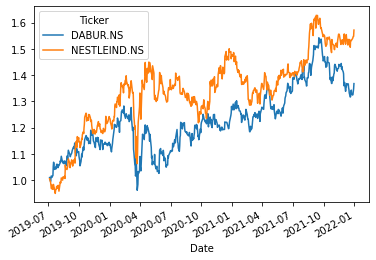

In [158]:
(returns+1).cumprod().plot()

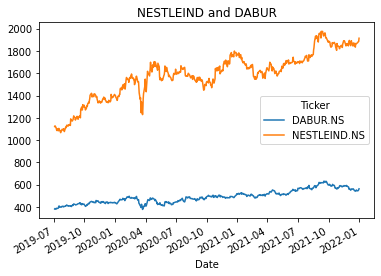

In [159]:
adj_close.plot()
plt.title('NESTLEIND and DABUR')
plt.show()

In [160]:
returns.columns=['NESTLEIND','DABUR']
tickers=['NESTLEIND','DABUR']
tickers

['NESTLEIND', 'DABUR']

In [161]:
stats.kendalltau(returns['NESTLEIND'], returns['DABUR'])[0]

0.2514463449303185

In [162]:
returns

,NESTLEIND,DABUR
Date,,
2019-07-05,0.010738,0.006078
2019-07-08,-0.014716,-0.013086
2019-07-09,0.012135,-0.009741
2019-07-10,0.008578,-0.011757
2019-07-11,-0.001221,-0.003786
...,...,...
2021-12-27,-0.003999,0.004057
2021-12-28,0.001779,0.002724
2021-12-29,0.007351,0.002304


{<scipy.stats._continuous_distns.norm_gen object at 0x00000240D7BB0520>, 'NESTLEIND', 0.0020140377803369394, -3402.304301258218, -3393.4513243433025}
{0.7378085589119474, <scipy.stats._continuous_distns.t_gen object at 0x00000240D7C1DAC0>, -3534.7176970086393, 'NESTLEIND', -3521.438231636266}
{0.47447107579126135, -3510.5752290804903, <scipy.stats._continuous_distns.genlogistic_gen object at 0x00000240D7BD7970>, 'NESTLEIND', -3497.295763708117}


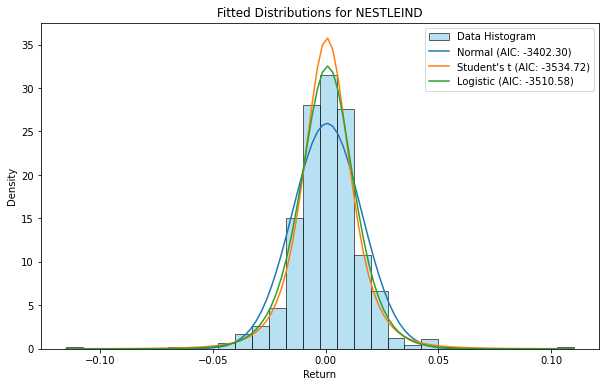

{'DABUR', -3323.6046773104226, -3314.751700395507, <scipy.stats._continuous_distns.norm_gen object at 0x00000240D7BB0520>, 0.00038795308633646165}
{0.5495257819332411, 'DABUR', -3449.7988320728546, <scipy.stats._continuous_distns.t_gen object at 0x00000240D7C1DAC0>, -3463.0782974452277}
{0.5488622049511758, -3423.0056325193354, 'DABUR', -3436.2850978917086, <scipy.stats._continuous_distns.genlogistic_gen object at 0x00000240D7BD7970>}


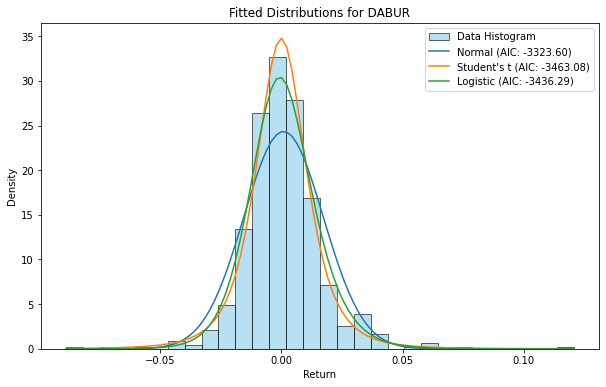

               Stock Distribution          AIC          BIC  KS_pvalue
NESTLEIND  NESTLEIND  Student's t -3534.717697 -3521.438232   0.737809
DABUR          DABUR  Student's t -3463.078297 -3449.798832   0.549526


In [163]:
marginals_df = pd.DataFrame(columns=['Stock','Distribution', 'AIC', 'BIC', 'KS_pvalue'])
for stock in tickers:
    data = returns[stock]
    dists = ['Normal', "Student's t", 'Logistic']
    best_aic = np.inf
    plt.figure(figsize=(10, 6))
    plt.hist(data, bins=30, density=True, alpha=0.6, color='skyblue', edgecolor='black', label="Data Histogram")
    for dist, name in zip(
        [stats.norm, stats.t, stats.genlogistic, stats.genextreme, stats.genpareto, stats.triang], 
        dists
    ):
        try:
            # Fit distribution parameters
            if name == 'Triangular':
                c = (data.mean() - data.min()) / (data.max() - data.min())
                params = (c, data.min(), data.max() - data.min())
            else:
                params = dist.fit(data)

            # Create frozen distribution instance
            dist_fit = dist(*params)
            
            # Calculate log-likelihood, AIC, and BIC
            log_like = np.log(dist_fit.pdf(data)).sum()
            aic = 2 * len(params) - 2 * log_like
            bic = len(params) * np.log(len(data)) - 2 * log_like
            
            # Perform K-S test
            ks_pval = stats.kstest(data, dist_fit.cdf, N=100)[1]
            print({stock,dist,aic,bic,ks_pval})

            # Update best distribution based on AIC
            if aic < best_aic:
                best_dist = name
                best_aic = aic
                best_bic = bic
                best_ks_pval = ks_pval

            # Plot the PDF of the fitted distribution
            x = np.linspace(data.min(), data.max(), 100)
            plt.plot(x, dist_fit.pdf(x), label=f"{name} (AIC: {aic:.2f})")

        except Exception as e:
            print(f"Error fitting {name} distribution for {stock}: {e}")

    # Store results in DataFrame
    marginals_df.loc[stock] = [stock,best_dist, best_aic, best_bic, best_ks_pval]

    # Finalize plot
    plt.title(f"Fitted Distributions for {stock}")
    plt.xlabel("Return")
    plt.ylabel("Density")
    plt.legend()
    plt.show()

print(marginals_df)

In [164]:
marginals_df = pd.DataFrame(index=tickers, columns=['Distribution', 'AIC', 'BIC', 'KS_pvalue'])
for stock in tickers:
    data = returns[stock]
    dists = ['Normal', "Student's t", 'Logistic', 'Extreme','GenPareto','Triangular']
    best_aic = np.inf
    for dist,name in zip([stats.norm, stats.t, stats.genlogistic, stats.genextreme], dists):
        params = dist.fit(data)
        dist_fit = dist(*params)
        log_like = np.log(dist_fit.pdf(data)).sum()
        aic = 2*len(params) - 2 * log_like
        if aic<best_aic:
            best_dist = name
            best_aic = aic
            best_bic = len(params) * np.log(len(data)) - 2 * log_like
            ks_pval = stats.kstest(data, dist_fit.cdf, N=100)[1]
    marginals_df.loc[stock] = [best_dist, best_aic, best_bic, ks_pval]
marginals_df

,Distribution,AIC,BIC,KS_pvalue
NESTLEIND,Student's t,-3534.717697,-3521.438232,0.737809
DABUR,Student's t,-3463.078297,-3449.798832,0.549526


In [165]:
pair = ('NESTLEIND','DABUR')
s1,s2 = pair
copulas_df = pd.DataFrame(columns=['parameter', 'aic', 'bic', 'KS_pvalue'])

# fit marginals
params_s1 = stats.t.fit(returns[s1])
dist_s1 = stats.t(*params_s1)
params_s2 = stats.t.fit(returns[s2])
dist_s2 = stats.t(*params_s2)
# apply probability integral transform
u = dist_s1.cdf(returns[s1])
v = dist_s2.cdf(returns[s2])


#for copula in [GaussianMultivariate()]:
for copula in [GaussianCopula(), ClaytonCopula(), GumbelCopula(), FrankCopula(), JoeCopula()]:
    copula.fit(u,v)
    L = copula.log_likelihood(u,v)
    aic = 2 * copula.num_params - 2 * L
    bic = copula.num_params * np.log(len(u)) - 2 * L
    copula_name = copula.name
    
    # calculate KS-pvalue
    smp = copula.sample(size=len(u)) # generate sample from fit copula
    s_u = smp[:,0]
    s_v = smp[:,1]
    ks_pval = ndtest.ks2d2s(u,v,s_u,s_v)
    
    if isinstance(copula, ArchimedeanCopula):
        best_param = copula.alpha
    else:
        best_param = copula.rho
    #print([copula_name, best_param, aic, bic, ks_pval])
    copulas_df.loc[copula_name] = [best_param, aic, bic, ks_pval]
copulas_df.to_csv('Copula_result.csv')
copulas_df

c:\Users\cheta\OneDrive\Documents\BTP\BTP_New Code\copulas.py:322: RuntimeWarning: invalid value encountered in power
  num = (u**(-alpha) * v**(-alpha) * (alpha+1) * (-1 + v**(-alpha) + u**(-alpha))**(-1/alpha))
c:\Users\cheta\OneDrive\Documents\BTP\BTP_New Code\copulas.py:28: RuntimeWarning: invalid value encountered in log
  return np.log(self.pdf(u,v)).sum()


,parameter,aic,bic,KS_pvalue
Gaussian,0.384781,-346.332044,-341.905555,0.490864
Clayton,0.590287,-93.852994,-89.426506,0.281460
Gumbel,1.317545,-109.880904,-105.454415,0.336903
Frank,2.451157,-88.649581,-84.223093,0.189858
Joe,1.389764,-86.166460,-81.739971,0.058017


In [166]:
tickers = ['NESTLEIND.ns','DABUR.ns']
s1 = "NESTLEIND"
s2 = "DABUR"
start = pd.to_datetime('2010-01-01')
end = pd.to_datetime('2024-11-03')
df = get(tickers, start, end)
adj_close = df.reset_index().pivot(index='Date', columns='Ticker', values='Adj Close')
returns_test = np.log(adj_close).diff().dropna()
returns_test

Ticker,DABUR.ns,NESTLEIND.ns
Date,,
2010-01-05,0.023876,0.000000
2010-01-06,0.016202,0.000000
2010-01-07,-0.024098,0.000000
2010-01-08,0.006988,-0.747976
2010-01-11,0.009941,0.001722
...,...,...
2024-10-28,0.027464,0.005008
2024-10-29,-0.032769,-0.002049
2024-10-30,0.019955,0.003918


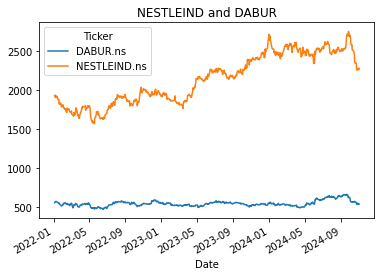

In [167]:
adj_close.loc['2022-1-04':'2024-11-03',:].plot()
plt.title('NESTLEIND and DABUR')
plt.show()

In [168]:
def get_prob_trading(data_source,fitting_period,predicting_period,start,end):
    '''
    calculate conditional probability based on Copula joint distribution
    '''
    
    s1,s2 = data_source.columns
    all_time_index = data_source.index
    trading_time_index = data_source.loc[start:end].index
    end_loc = all_time_index.get_loc(trading_time_index[-1])
    prob_s1 = []
    prob_s2 = []
    cnts = []

    for t in trading_time_index[::predicting_period]:
        start_loc = all_time_index.get_loc(t)
        if start_loc < fitting_period:
            print(f"Skipping index {start_loc} due to insufficient data for fitting period.")
            continue
        fitting_return = data_source.iloc[start_loc-fitting_period:start_loc]
        predicting_return = data_source.iloc[start_loc:min(start_loc+predicting_period,end_loc+1)]
        
        # fit marginals
        # print("fitting_return[s1]:", fitting_return[s1])
        # print("fitting_return[s2]:", fitting_return[s2])
        params_s1 = stats.t.fit(fitting_return[s1])
        dist_s1 = stats.t(*params_s1)
        params_s2 = stats.t.fit(fitting_return[s2])
        dist_s2 = stats.t(*params_s2)

        # transform marginals
        u = dist_s1.cdf(fitting_return[s1])
        v = dist_s2.cdf(fitting_return[s2])

        copulas = GaussianCopula()
        copulas.fit(u,v)

        cnt = 0

        for u,v in zip(dist_s1.cdf(predicting_return[s1]), dist_s2.cdf(predicting_return[s2])):
            cnt += 1
            prob_s1.append(copulas.cdf_u_given_v(u,v))
            prob_s2.append(copulas.cdf_v_given_u(u,v))

        cnts.append((cnt, t))

    print(cnts)
    vals = np.vstack([prob_s1, prob_s2]).T
    probs_trade = pd.DataFrame(vals, index=trading_time_index, columns=[s1, s2])
    return probs_trade

In [169]:
def pair_strategy(data_source,probs_trade,cl,cl_close):
    '''
    conduct pairs trading based on conditional probability
    '''
    s1 = probs_trade.columns[0]
    s2 = probs_trade.columns[1]
    positions = pd.DataFrame(index=probs_trade.index, columns=probs_trade.columns)
    long = False
    short = False
    for t in positions.index:    
        # if long position is open
        if long:
            if (probs_trade.loc[t][s1] > (1-cl_close)) or (probs_trade.loc[t][s2] < cl_close):
                positions.loc[t] = [0,0]
                long = False
            else:
                positions.loc[t] = [1,-1]

        # if short position is open
        elif short:
            if (probs_trade.loc[t][s1] < cl_close) or (probs_trade.loc[t][s2] > (1-cl_close)):
                positions.loc[t] = [0,0]
                short = False
            else:
                positions.loc[t] = [-1,1]

        # if no positions are open
        else:
            if (probs_trade.loc[t][s1] < (1-cl)) and (probs_trade.loc[t][s2] > cl):
                # open long position
                positions.loc[t] = [1,-1]
                long = True
            elif (probs_trade.loc[t][s1] > cl) and (probs_trade.loc[t][s2] < (1-cl)):
                # open short positions
                positions.loc[t] = [-1,1]
                short = True
            else:
                positions.loc[t] = [0,0]

    # calculate returns
    returns_trade = data_source.loc[probs_trade.index]
    algo_returns = {}
    algo_ret = (returns_trade * positions.shift(1)).sum(axis=1)
    algo_returns['pair'] = algo_ret
    returns_df = pd.DataFrame.from_dict(algo_returns)
    returns_df = returns_df.apply(pd.to_numeric, errors='coerce').astype(float)
    returns_df = np.exp(returns_df) - 1 # convert log-returns to simple returns
    total_ret = returns_df.sum(axis=1) / len(returns_df.columns) * 2 # double capital (from short positions)

    a = pd.DataFrame(data={'algo':np.nancumprod(total_ret + 1),s1:np.nancumprod(returns_trade[s1] + 1),s2:np.nancumprod(returns_trade[s2] + 1)},index=probs_trade.index)
    return a

In [170]:
fitting_period = 500
predicting_period = 100
start = '2022-1-04'
end = '2024-11-03'
probs_trade = get_prob_trading(returns_test,fitting_period,predicting_period,start,end)

[(100, Timestamp('2022-01-04 00:00:00')), (100, Timestamp('2022-06-01 00:00:00')), (100, Timestamp('2022-10-25 00:00:00')), (100, Timestamp('2023-03-20 00:00:00')), (100, Timestamp('2023-08-16 00:00:00')), (100, Timestamp('2024-01-11 00:00:00')), (99, Timestamp('2024-06-12 00:00:00'))]


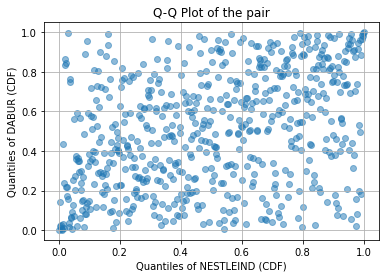

In [171]:
df_normalized = returns.apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)) )
data1=df_normalized['NESTLEIND']
data2=df_normalized['DABUR']
cdf1 = stats.rankdata(data1) / len(data1)  # Empirical CDF for data1
cdf2 = stats.rankdata(data2) / len(data2)  # Empirical CDF for data2
plt.scatter(cdf1, cdf2, alpha=0.5)
plt.title("Q-Q Plot of the pair")
plt.xlabel("Quantiles of NESTLEIND (CDF)")
plt.ylabel("Quantiles of DABUR (CDF)")
plt.grid(True)
plt.show()

In [172]:
probs_trade

,DABUR.ns,NESTLEIND.ns
Date,,
2022-01-04,0.061015,0.925253
2022-01-05,0.873289,0.408552
2022-01-06,0.667329,0.117771
2022-01-07,0.618669,0.802216
2022-01-10,0.711597,0.174218
...,...,...
2024-10-28,0.979197,0.352650
2024-10-29,0.010243,0.741057
2024-10-30,0.951111,0.367864


<Axes: xlabel='Date'>

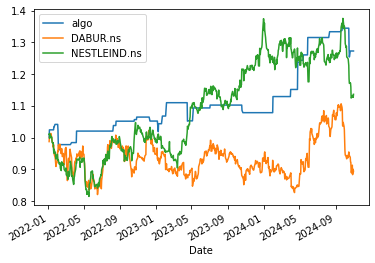

In [173]:
cl = 0.90
cl_close = 0.5
pair_strategy(returns_test,probs_trade,cl,cl_close).plot()

Text(0.5, 1.0, 'the performance of Pairs Trading compared with indexes')

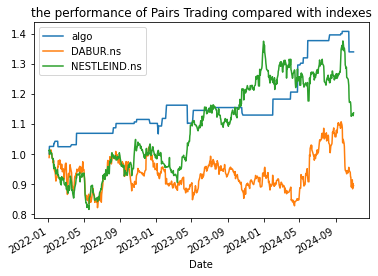

In [174]:
cl = 0.90
cl_close = 0.65
pair_strategy(returns_test,probs_trade,cl,cl_close).plot()
plt.title('the performance of Pairs Trading compared with indexes')

In [175]:
def calculate_metrics(cumret):
    '''
    calculate performance metrics from cumulative returns
    '''
    total_return = (cumret[-1] - cumret[0])/cumret[0]
    apr = (1+total_return)**(252/len(cumret)) - 1
    rets = pd.DataFrame(cumret).pct_change()
    sharpe = np.sqrt(252) * np.nanmean(rets) / np.nanstd(rets)
    
    # maxdd and maxddd
    highwatermark=np.zeros(cumret.shape)
    drawdown=np.zeros(cumret.shape)
    drawdownduration=np.zeros(cumret.shape)
    for t in np.arange(1, cumret.shape[0]):
        highwatermark[t]=np.maximum(highwatermark[t-1], cumret[t])
        drawdown[t]=cumret[t]/highwatermark[t]-1
        if drawdown[t]==0:
            drawdownduration[t]=0
        else:
            drawdownduration[t]=drawdownduration[t-1]+1
    maxDD=np.min(drawdown)
    maxDDD=np.max(drawdownduration)
    
    return total_return, apr, sharpe, maxDD

In [176]:
total_ret = pair_strategy(returns_test,probs_trade,0.9,0.5)
metrics = pd.DataFrame(columns=['Total return', 'APR', 'Sharpe', 'MaxDD'])
metrics.loc['algo'] = calculate_metrics(total_ret['algo'])
metrics.loc['NESTLEIND.ns'] = calculate_metrics(total_ret['NESTLEIND.ns'])
metrics.loc['DABUR.ns'] = calculate_metrics(total_ret['DABUR.ns'])
metrics

,Total return,APR,Sharpe,MaxDD
algo,0.272986,0.090914,0.928023,-0.077202
NESTLEIND.ns,0.124604,0.043245,0.319479,-0.195418
DABUR.ns,-0.094516,-0.035161,-0.054568,-0.201673
